In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np
import datetime
import gmaps
from scipy import stats
from config import api_key, g_key
from pprint import pprint
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
#test

In [2]:
geo_path = 'Resources/data/GeoIDs - County.csv'
county_covid_path = 'Resources/data/COVID - County - Daily.csv'
emp_comb_path = 'Resources/data/Employment Combined - State - Daily.csv'
dol_path = 'Resources/MI_DOL_EMP_STATS.csv'

In [3]:
blsApi_url = 'https://api.bls.gov/publicAPI/v2/timeseries/data/'
covid_url = 'https://api.covidtracking.com/v1/states/mi/daily.json'
geocode_url = 'https://maps.googleapis.com/maps/api/geocode/json'

In [4]:
# Creating and cleaning DataFrame
response = (requests.get(covid_url).json())
covid_df = pd.DataFrame(response)
covid_df.dropna(axis=1, how='all', inplace = True)
del covid_df['hospitalizedIncrease'],covid_df['hash'],covid_df['commercialScore'],covid_df['negativeRegularScore'],covid_df['negativeScore'],covid_df['positiveScore'],covid_df['score'],covid_df['grade']
covid_df = covid_df.drop(columns = ['lastUpdateEt','dateModified','checkTimeEt','recovered','dataQualityGrade','totalTestResultsSource','dateChecked'])
covid_df.head()

,date,state,positive,negative,pending,totalTestResults,hospitalizedCurrently,inIcuCurrently,onVentilatorCurrently,death,totalTestsViral,positiveTestsViral,negativeTestsViral,positiveCasesViral,deathConfirmed,deathProbable,totalTestsAntibody,fips,positiveIncrease,negativeIncrease,total,totalTestResultsIncrease,posNeg,deathIncrease
0,20200929,MI,136820,3481264.0,NaN,3618084,557.0,137.0,60.0,7072.0,3653724.0,172460.0,3481264.0,123633,6751.0,321,292652.0,26,1118,22976,3618084,24094,3618084,21
1,20200928,MI,135702,3458288.0,NaN,3593990,557.0,137.0,51.0,7051.0,3629903.0,171615.0,3458288.0,122735,6731.0,320,292255.0,26,1329,49604,3593990,50933,3593990,7
2,20200927,MI,134373,3408684.0,NaN,3543057,558.0,139.0,52.0,7044.0,3578584.0,169900.0,3408684.0,121427,6723.0,321,291180.0,26,0,0,3543057,0,3543057,0
3,20200926,MI,134373,3408684.0,NaN,3543057,558.0,139.0,52.0,7044.0,3578584.0,169900.0,3408684.0,121427,6723.0,321,291180.0,26,996,39749,3543057,40745,3543057,17
4,20200925,MI,133377,3368935.0,NaN,3502312,558.0,139.0,52.0,7027.0,3537643.0,168708.0,3368935.0,120526,6708.0,319,289151.0,26,1040,38448,3502312,39488,3502312,8


In [5]:
# Trying to create consistent datetime column ot use with merge.
covid_dates = [datetime.date(int(str(x)[0:4]), int(str(x)[5]), int(str(x)[6:8])) for x in covid_df['date']]
covid_df['datetimes']=covid_dates



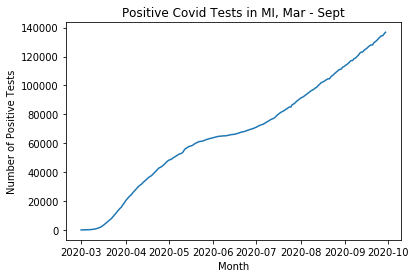

In [6]:
plt.plot(covid_df['datetimes'], covid_df['positive'])
plt.title('Positive Covid Tests in MI, Mar - Sept')
plt.ylabel('Number of Positive Tests')
plt.xlabel('Month')
plt.show()

In [7]:

emp_comb_df = pd.read_csv(emp_comb_path)
mi_emp_comb_df = emp_comb_df.loc[emp_comb_df['statefips']==26] #MI fips is 26
mi_emp_comb_df.head()

,year,month,day,statefips,emp_combined,emp_combined_inclow,emp_combined_incmiddle,emp_combined_inchigh,emp_combined_ss40,emp_combined_ss60,emp_combined_ss65,emp_combined_ss70
22,2020,1,15,26,-0.001230,-.000268,-.00115,-0.00255,-.000196,-.00234,.000193,-.00555
73,2020,1,16,26,-0.000679,.000682,-.000624,-0.00245,-.000276,-.0022,.000653,-.00418
124,2020,1,17,26,-0.000132,.00163,-.0000949,-0.00235,-.000307,-.00203,.00112,-.00278
175,2020,1,18,26,0.000427,.00262,.000434,-0.00226,-.000312,-.00186,.00164,-.00117
226,2020,1,19,26,0.000985,.00361,.000963,-0.00216,-.000317,-.00169,.00215,.000433


In [8]:
mi_emp_comb_df['number employed'] = (mi_emp_comb_df.iloc[:, 4] * 4774000)+4774000
mi_emp_comb_df[['emp_combined_inclow', 'emp_combined', 'emp_combined_incmiddle', 'emp_combined_inchigh']]= mi_emp_comb_df[['emp_combined_inclow', 'emp_combined', 'emp_combined_incmiddle', 'emp_combined_inchigh']].astype(float)*100
date = []
per_change = []
#Creating consistent datetime across dfs
for index in mi_emp_comb_df.index:
    date.append(datetime.date(mi_emp_comb_df.loc[index, 'year'],mi_emp_comb_df.loc[index, 'month'],mi_emp_comb_df.loc[index, 'day']))
    per_change.append(mi_emp_comb_df.loc[index, 'emp_combined'])
mi_emp_comb_df['datetimes'] = date
mi_emp_comb_df['emp_expected'] = mi_emp_comb_df['emp_combined'].mean()
mi_emp_comb_df

C:\Users\state\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\state\anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\state\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

,year,month,day,statefips,emp_combined,emp_combined_inclow,emp_combined_incmiddle,emp_combined_inchigh,emp_combined_ss40,emp_combined_ss60,emp_combined_ss65,emp_combined_ss70,number employed,datetimes,emp_expected
22,2020,1,15,26,-0.1230,-0.0268,-0.11500,-0.2550,-.000196,-.00234,.000193,-.00555,4768127.980,2020-01-15,-10.851375
73,2020,1,16,26,-0.0679,0.0682,-0.06240,-0.2450,-.000276,-.0022,.000653,-.00418,4770758.454,2020-01-16,-10.851375
124,2020,1,17,26,-0.0132,0.1630,-0.00949,-0.2350,-.000307,-.00203,.00112,-.00278,4773369.832,2020-01-17,-10.851375
175,2020,1,18,26,0.0427,0.2620,0.04340,-0.2260,-.000312,-.00186,.00164,-.00117,4776038.498,2020-01-18,-10.851375
226,2020,1,19,26,0.0985,0.3610,0.09630,-0.2160,-.000317,-.00169,.00215,.000433,4778702.390,2020-01-19,-10.851375
277,2020,1,20,26,0.1540,0.4600,0.14900,-0.2070,-.000322,-.00152,.00267,.00204,4781351.960,2020-01-20,-10.851375
328,2020,1,21,26,0.2050,0.5390,0.20200,-0.1970,-.000369,-.00136,.00313,.00331,4783786.700,2020-01-21,-10.851375
379,2020,1,22,26,0.2550,0.6180,0.25500,-0.1870,-.000388,-.00118,.00358,.00452,4786173.700,2020-01-22,-10.851375
430,2020,1,23,26,0.2600,0.5950,0.25200,-0.1320,-.000475,-.000452,.00355,.00498,4786412.400,2020-01-23,-10.851375
481,2020,1,24,26,0.2610,0.5580,0.24900,-0.0773,-.000606,.000234,.00348,.00538,4786460.140,2020-01-24,-10.851375


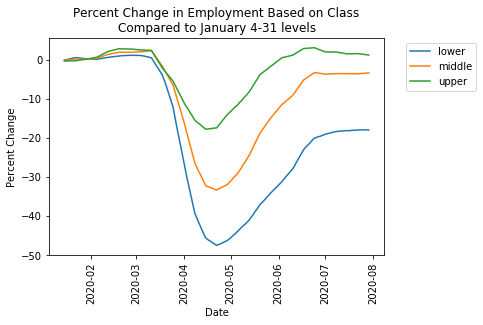

In [9]:

mi_emp_comb_df.plot('datetimes', ['emp_combined_inclow' , 'emp_combined_incmiddle', 'emp_combined_inchigh'], kind = 'line')
plt.title('Percent Change in Employment Based on Class\nCompared to January 4-31 levels')
plt.xlabel('Date')
plt.xticks(rotation = 90)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', labels = ['lower', 'middle', 'upper'])
plt.ylabel('Percent Change')
plt.show()

C:\Users\state\anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


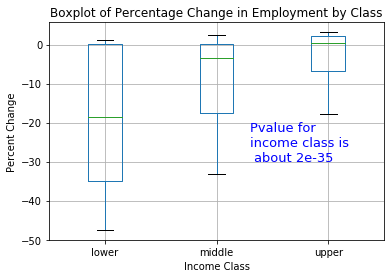

In [10]:

low = mi_emp_comb_df['emp_combined_inclow']
middle = mi_emp_comb_df['emp_combined_incmiddle']
high = mi_emp_comb_df['emp_combined_inchigh']
annova = (stats.f_oneway(low, middle, high))

#I dont rename here as I coded this section after a i had extensively used some of the column names.
mi_emp_comb_df[['lower', 'middle', 'upper']]=mi_emp_comb_df[['emp_combined_inclow', 'emp_combined_incmiddle', 'emp_combined_inchigh']]
mi_emp_comb_df.boxplot(['lower', 'middle', 'upper'])
plt.ylabel('Percent Change')
plt.title('Boxplot of Percentage Change in Employment by Class')
plt.xlabel('Income Class')
plt.annotate(f'Pvalue for \nincome class is \n about {round(annova[1], 35)}', (2.3, -30), fontsize = 13, color = 'blue')
plt.show()

#Alternative
#in the last six months, lower class was affected more by covid 19 than any other class

# Null
# in the last six months, employment is uncorrellated with income level throughout the pandemic.


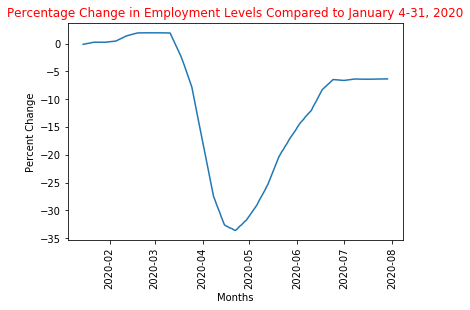

In [11]:



# x_values = date
# y_values = per_change

# fig, ax1 = plt.subplots()
# ax1.set_xlabel('Date')
# ax1.plot(x_values, y_values)
# plt.xticks(rotation = 45)
# plt.legend(labels = ['Percent Change in Employment'], bbox_to_anchor=(1.2, .8), loc='upper left')
# plt.ylabel('Percent Change')
# ax2  = ax1.twinx()
# ax2.plot(covid_df['datetimes'], covid_df['positive'], color = 'green')
# ax2.legend(labels = ['Positive Covid Tests'], bbox_to_anchor=(1.2, 1), loc='upper left')
# plt.xlabel('Months')
# plt.ylabel('Number of Tests')

# plt.title('Percent Change in Employment and Positive Covid Tests over time')
# plt.show()





x_values = date
y_values = per_change


fig1  = plt.plot(x_values, y_values)


plt.title('Percentage Change in Employment Levels Compared to January 4-31, 2020', color = 'red')
plt.xticks(rotation = 90)
plt.xlabel('Months')
plt.ylabel('Percent Change')



plt.show()



r^2 value: 0.15335440072049702


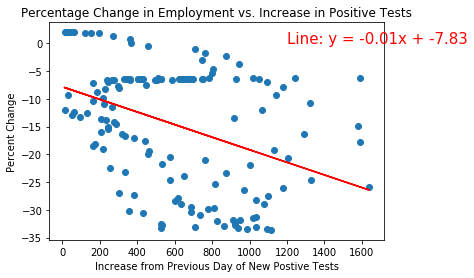

In [12]:
covid_emp_merge = pd.merge(covid_df, mi_emp_comb_df, on='datetimes', how = 'inner')
covid_emp_merge = covid_emp_merge.loc[covid_emp_merge['positiveIncrease']!=0]
x_values = covid_emp_merge['positiveIncrease']
y_values = covid_emp_merge['emp_combined']
plt.scatter(x_values, y_values)
plt.title('Percentage Change in Employment vs. Increase in Positive Tests')
plt.ylabel('Percent Change')
plt.xlabel('Increase from Previous Day of New Postive Tests')

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "Line: y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(1200,0),fontsize=15,color="red")
print(f'r^2 value: {rvalue*rvalue}')
plt.show()

In [13]:

dol_emp_df = pd.read_csv(dol_path, encoding='UTF-8')
dol_emp_df = dol_emp_df.sort_values(['Period Year (copy)', 'PeriodCode (copy)'] ,ascending=False)
unadjusted = dol_emp_df.loc[(dol_emp_df['Adjustment'] == 'Not Adj') & (dol_emp_df['Year'] == 2020)]
unadjusted['PeriodCode']+= 1
unadjusted

C:\Users\state\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Period Year (copy),PeriodCode (copy),ID,Region,Area,Year,Period,Adjustment,Preliminary,Area Type,Period Type Description,StateSelected,Adjusted,PeriodCode,Prelim,State Code,State Name,Employed,Labor Force,Unemployed,Unemployment Rate
9,2020,8,3403524,MI,Michigan,2020,August,Not Adj,Yes,State,Monthly,True,0,9,1,26,Michigan,"4,502,000","4,941,000","440,000",8.9
2,2020,7,3403522,MI,Michigan,2020,July,Not Adj,No,State,Monthly,True,0,8,0,26,Michigan,"4,406,000","4,871,000","465,000",9.5
50,2020,6,3403520,MI,Michigan,2020,June,Not Adj,No,State,Monthly,True,0,7,0,26,Michigan,"4,240,000","4,988,000","748,000",15.0
47,2020,5,3403518,MI,Michigan,2020,May,Not Adj,No,State,Monthly,True,0,6,0,26,Michigan,"3,773,000","4,765,000","992,000",20.8
44,2020,4,3403516,MI,Michigan,2020,April,Not Adj,No,State,Monthly,True,0,5,0,26,Michigan,"3,477,000","4,553,000","1,076,000",23.6
65,2020,3,3403514,MI,Michigan,2020,March,Not Adj,No,State,Monthly,True,0,4,0,26,Michigan,"4,702,000","4,900,000","198,000",4.0
62,2020,2,3403512,MI,Michigan,2020,February,Not Adj,No,State,Monthly,True,0,3,0,26,Michigan,"4,774,000","4,953,000","180,000",3.6
59,2020,1,3403510,MI,Michigan,2020,January,Not Adj,No,State,Monthly,True,0,2,0,26,Michigan,"4,714,000","4,924,000","211,000",4.3


In [14]:
#Accessing API based on Documentation, must dig deep into website to find relevant information
# Series IDs for BLS datasets SMU26000000000000001 SMU26000000500000001 SMU26000000500000002 SMU26000000500000011 SMU26000000600000001 SMU26000000600000002 SMU26000000600000011 SMU26000000700000001 SMU26000000800000001 SMU26000000800000002 SMU26000000800000011



blsApi_url = 'https://api.bls.gov/publicAPI/v2/timeseries/data/'
headers = {'Content-type': 'application/json'}
data =  json.dumps({"seriesid": ['SMU26000000000000001', 'SMU26000000500000001', 'SMU26000000500000002', 'SMU26000000500000011', 'SMU26000000600000001', 'SMU26000000600000002', 'SMU26000000600000011', 'SMU26000000700000001', 'SMU26000000800000001', 'SMU26000000800000002', 'SMU26000000800000011'],
                    'catalog':True,
                    "registrationkey" : f'{api_key}'})
bls_json = (requests.post(blsApi_url, data=data, headers = headers).json())


In [15]:
#Data Parsing
dframes = {}
# Loop creates dictionary dframes with keys being Commerce Industry + Measure Data Type from metadata and values are pandas dataframes
for series in bls_json['Results']['series']:
    dframes.update({series['catalog']['commerce_industry'] +' '+ series['catalog']['measure_data_type']:pd.DataFrame(series['data'])})
full_bls_df = dframes['Total Nonfarm All Employees, In Thousands']
for df_name, value_df in dframes.items():
    full_bls_df[df_name] = value_df['value']
full_bls_df = full_bls_df.drop(columns=['value', 'latest', 'footnotes'])
full_bls_df.iloc[:, np.arange(3,len(full_bls_df.columns))]=full_bls_df.iloc[:, np.arange(3,len(full_bls_df.columns))].astype(float)
full_bls_df.head()

,year,period,periodName,"Total Nonfarm All Employees, In Thousands","Total Private All Employees, In Thousands",Total Private Average Weekly Hours of All Employees,"Total Private Average Weekly Earnings of All Employees, In Dollars","Goods Producing All Employees, In Thousands",Goods Producing Average Weekly Hours of All Employees,"Goods Producing Average Weekly Earnings of All Employees, In Dollars","Service-Providing All Employees, In Thousands","Private Service Providing All Employees, In Thousands",Private Service Providing Average Weekly Hours of All Employees,"Private Service Providing Average Weekly Earnings of All Employees, In Dollars"
0,2020,M08,August,3983.1,3437,34.8,958.39,756.4,40.6,1175.37,3226.7,2680.6,33.2,898.39
1,2020,M07,July,3924.8,3398.1,34.4,935.34,750.3,39.8,1125.94,3174.5,2647.8,32.8,879.7
2,2020,M06,June,3889.6,3333.6,34.3,936.73,743.5,39.4,1108.32,3146.1,2590.1,32.8,886.58
3,2020,M05,May,3598.5,3034.5,34.1,955.82,635.3,38.4,1111.68,2963.2,2399.2,32.9,912.98
4,2020,M04,April,3391.2,2798.6,32.6,935.95,539.7,36.7,1088.16,2851.5,2258.9,31.7,901.87


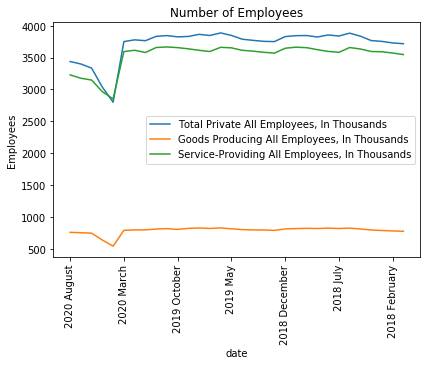

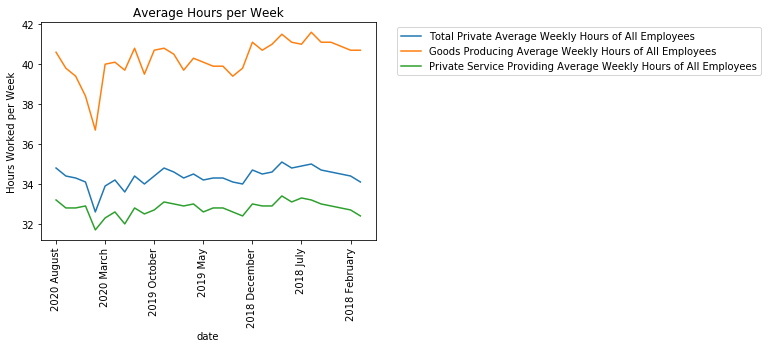

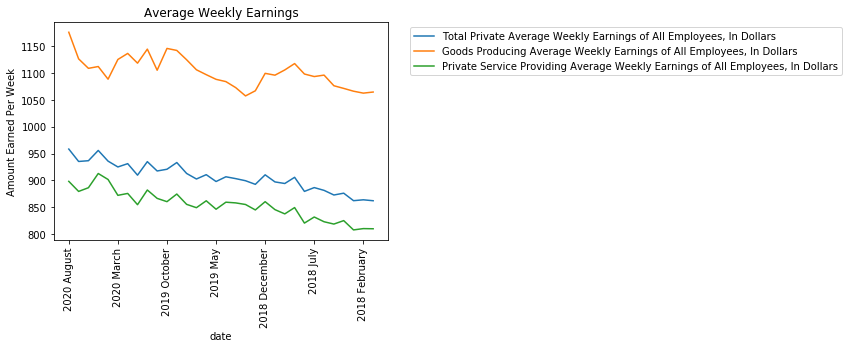

In [16]:
full_bls_df['date'] = full_bls_df['year']+' ' +full_bls_df['periodName']
full_bls_df.plot('date',['Total Private All Employees, In Thousands','Goods Producing All Employees, In Thousands', 'Service-Providing All Employees, In Thousands' ],  kind = 'line')
plt.tight_layout()
plt.title('Number of Employees')
plt.xticks(rotation = 90)
plt.ylabel('Employees')
full_bls_df.plot('date', ['Total Private Average Weekly Hours of All Employees', 'Goods Producing Average Weekly Hours of All Employees', 'Private Service Providing Average Weekly Hours of All Employees' ], kind = 'line')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation = 90)
plt.ylabel('Hours Worked per Week')
plt.title('Average Hours per Week')
full_bls_df.plot('date', ['Total Private Average Weekly Earnings of All Employees, In Dollars', 'Goods Producing Average Weekly Earnings of All Employees, In Dollars', 'Private Service Providing Average Weekly Earnings of All Employees, In Dollars' ], kind = 'line')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation = 90)
plt.title('Average Weekly Earnings')
plt.ylabel('Amount Earned Per Week')
plt.show()

In [17]:

geo_id_df = pd.read_csv(geo_path)
county_covid_df = pd.read_csv(county_covid_path)
mi_county_id_df = geo_id_df.loc[geo_id_df['statename']=='Michigan']
mi_county_covid_df = pd.merge(county_covid_df, mi_county_id_df, on='countyfips', how='inner')
county_single_day = mi_county_covid_df.loc[(mi_county_covid_df['month']==9) & (mi_county_covid_df['day']==20)]
county_single_day


C:\Users\state\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (4,5,6,7,8,9,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,year,month,day,countyfips,case_count,new_case_count,death_count,new_death_count,case_rate,death_rate,new_case_rate,new_death_rate,countyname,cz,czname,statename,statefips,stateabbrev,county_pop2019
243,2020,9,20,26001,41,0,2,0,394,19.2,1.37,0,Alcona,12401.0,Alpena,Michigan,26,MI,10405
487,2020,9,20,26003,17,0,0,0,187,0,0,0,Alger,11401.0,Marquette,Michigan,26,MI,9108
731,2020,9,20,26005,729,0,7,0,617,5.93,4.23,0,Allegan,12200.0,Grand Rapids,Michigan,26,MI,118081
975,2020,9,20,26007,139,0,14,0,489,49.3,3.52,0,Alpena,12401.0,Alpena,Michigan,26,MI,28405
1219,2020,9,20,26009,66,0,0,0,283,0,1.22,0,Antrim,12301.0,Traverse City,Michigan,26,MI,23324
1463,2020,9,20,26011,69,0,3,0,464,20.2,2.88,0,Arenac,11900.0,Saginaw,Michigan,26,MI,14883
1707,2020,9,20,26013,14,0,0,0,171,0,5.22,0,Baraga,21002.0,Houghton,Michigan,26,MI,8209
1951,2020,9,20,26015,272,0,2,0,442,3.25,3.48,0,Barry,12100.0,Kalamazoo,Michigan,26,MI,61550
2195,2020,9,20,26017,956,0,48,0,927,46.5,7.34,.277,Bay,11900.0,Saginaw,Michigan,26,MI,103126
2439,2020,9,20,26019,69,0,2,0,388,11.3,4.82,0,Benzie,12301.0,Traverse City,Michigan,26,MI,17766


In [19]:

locations = []

for index, row in county_single_day.iterrows():
    county = row['countyname']
    state = row['stateabbrev']
    params = {'key': g_key,
             'address': f'{county} {state}'}
    county_json = requests.get(geocode_url, params = params).json()
    try:
        lat = (county_json['results'][0]['geometry']['location']['lat'])
        lng = county_json['results'][0]['geometry']['location']['lng']
        locations.append((lat, lng))
    except IndexError:
        locations.append((0, 0))
county_single_day['location'] = locations
county_single_day


C:\Users\state\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,year,month,day,countyfips,case_count,new_case_count,death_count,new_death_count,case_rate,death_rate,new_case_rate,new_death_rate,countyname,cz,czname,statename,statefips,stateabbrev,county_pop2019,location
243,2020,9,20,26001,41,0,2,0,394,19.2,1.37,0,Alcona,12401.0,Alpena,Michigan,26,MI,10405,"(0, 0)"
487,2020,9,20,26003,17,0,0,0,187,0,0,0,Alger,11401.0,Marquette,Michigan,26,MI,9108,"(0, 0)"
731,2020,9,20,26005,729,0,7,0,617,5.93,4.23,0,Allegan,12200.0,Grand Rapids,Michigan,26,MI,118081,"(0, 0)"
975,2020,9,20,26007,139,0,14,0,489,49.3,3.52,0,Alpena,12401.0,Alpena,Michigan,26,MI,28405,"(0, 0)"
1219,2020,9,20,26009,66,0,0,0,283,0,1.22,0,Antrim,12301.0,Traverse City,Michigan,26,MI,23324,"(0, 0)"
1463,2020,9,20,26011,69,0,3,0,464,20.2,2.88,0,Arenac,11900.0,Saginaw,Michigan,26,MI,14883,"(0, 0)"
1707,2020,9,20,26013,14,0,0,0,171,0,5.22,0,Baraga,21002.0,Houghton,Michigan,26,MI,8209,"(0, 0)"
1951,2020,9,20,26015,272,0,2,0,442,3.25,3.48,0,Barry,12100.0,Kalamazoo,Michigan,26,MI,61550,"(0, 0)"
2195,2020,9,20,26017,956,0,48,0,927,46.5,7.34,.277,Bay,11900.0,Saginaw,Michigan,26,MI,103126,"(0, 0)"
2439,2020,9,20,26019,69,0,2,0,388,11.3,4.82,0,Benzie,12301.0,Traverse City,Michigan,26,MI,17766,"(0, 0)"


In [ ]:
gmaps.configure(api_key = g_key)
fig = gmaps.figure()
heatmap = gmaps.heatmap_layer(locations = locations, weights = county_single_day['case_count'], max_intensity=5111, point_radius=20)
fig.add_layer(heatmap)
fig
